In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score, roc_curve, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/healthcare_data_cleaned.csv')

In [3]:
df.drop(["ptid"], axis=1, inplace=True)

In [4]:
#encoding persistency flag
df["persistency_flag"] = df["persistency_flag"].apply(lambda x: 1 if x == "Persistent" else 0)

In [5]:
X = df.drop(["persistency_flag"], axis=1)
Y = df["persistency_flag"]

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.30, random_state=1, stratify=Y)

In [6]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (2396, 103)
Shape of test set :  (1028, 103)
Percentage of classes in training set:
persistency_flag
0    0.623539
1    0.376461
Name: proportion, dtype: float64
Percentage of classes in test set:
persistency_flag
0    0.623541
1    0.376459
Name: proportion, dtype: float64


In [7]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [8]:
#function to plot confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [9]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [10]:
rf_model_perf_train = model_performance_classification_sklearn(rf_model, X_train, y_train)
rf_model_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [11]:
rf_model_perf_test = model_performance_classification_sklearn(rf_model, X_test, y_test)
rf_model_perf_test

,Accuracy,Recall,Precision,F1
0,0.814202,0.684755,0.793413,0.73509


###Hyperparameter tuning

In [12]:
rf_model_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
param_grid = {
    "n_estimators": [50,110,25],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_model_tuned, param_grid, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_model_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_model_tuned.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=110, random_state=1)

####Testing the tuned model

In [13]:
rf_model_tuned_perf_train = model_performance_classification_sklearn(rf_model_tuned, X_train, y_train)
rf_model_tuned_perf_train

,Accuracy,Recall,Precision,F1
0,0.986227,0.966741,0.996571,0.981429


In [14]:
rf_model_tuned_perf_test = model_performance_classification_sklearn(rf_model_tuned, X_test, y_test)
rf_model_tuned_perf_test

,Accuracy,Recall,Precision,F1
0,0.814202,0.666667,0.80625,0.729844


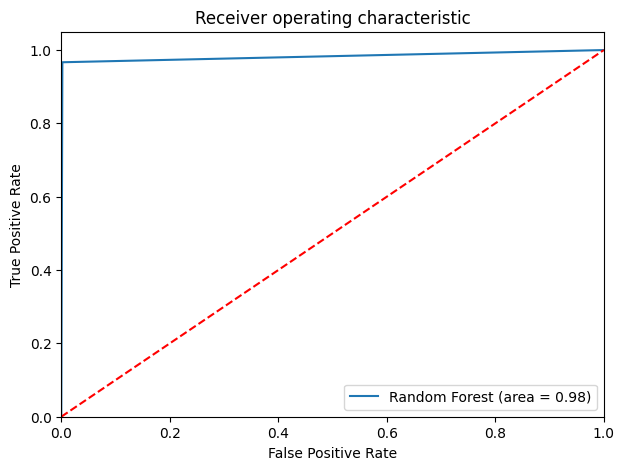

In [15]:
rf_roc_auc_train = roc_auc_score(y_train, rf_model_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, rf_model_tuned.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Random Forest (area = %0.2f)" % rf_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

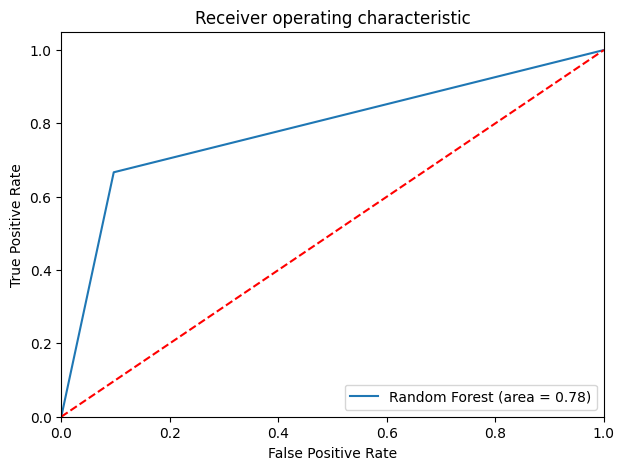

In [16]:
rf_roc_auc_test = roc_auc_score(y_test, rf_model_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_model_tuned.predict(X_test))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Random Forest (area = %0.2f)" % rf_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()